# Aircraft Crashes Data Clustering

## Overview

This notebook explores different clustering of aircraft accidents since 1970 and compares the different results. The data has already been cleaned in the [EDA notebook](data_analysis.ipynb).

## Data Preprocessing

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from yellowbrick.cluster import KElbowVisualizer

In [33]:
# Load data
with open('data/cleaned_data.pkl', 'rb') as handle:
	df = pickle.load(handle)
df.head()

,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities,cause
0,1970-01-02,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951,Multi Piston Engines,Unknown,Landing (descent or approach),Cargo,Mountains,"Long Tieng, Vientiane Province",Laos,Asia,20.017111,103.378253,Destroyed,4,4,0,Unknown
1,1970-01-02,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943,Multi Piston Engines,Unknown,Takeoff (climb),Training,Airport (less than 10 km from airport),"North Little Rock-Municipal, Arkansas",United States of America,North America,34.832246,-92.259758,Destroyed,2,0,0,Human factor
2,1970-01-03,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Phan Rang, Ninh Thuận Province",Vietnam,Asia,11.576983,108.986539,Unknown,5,0,0,Technical failure
3,1970-01-05,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"La Palma (La Palma Island), Canary Islands",Spain,Europe,28.655116,-17.857269,Destroyed,49,0,0,Unknown
4,1970-01-05,Accident,Convair CV-990,Spantax,1962,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),Positioning,Airport (less than 10 km from airport),"Stockholm-Arlanda, Uppland",Sweden,Europe,59.674971,14.520858,Destroyed,10,5,0,Human factor


In [35]:
# Split date in three columns
df.insert(0, 'year', df['date'].dt.year)
df.insert(1, 'month', df['date'].dt.month)
df.insert(2, 'day', df['date'].dt.day)
df = df.drop('date', axis=1)
df.head()

,year,month,day,category,type,operator,yom,engine,engine_model,flight_phase,...,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities,cause
0,1970,1,2,Accident,Douglas DC-3,Xieng Khouang Air Transport,1951,Multi Piston Engines,Unknown,Landing (descent or approach),...,"Long Tieng, Vientiane Province",Laos,Asia,20.017111,103.378253,Destroyed,4,4,0,Unknown
1,1970,1,2,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943,Multi Piston Engines,Unknown,Takeoff (climb),...,"North Little Rock-Municipal, Arkansas",United States of America,North America,34.832246,-92.259758,Destroyed,2,0,0,Human factor
2,1970,1,3,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954,Unknown,Unknown,Landing (descent or approach),...,"Phan Rang, Ninh Thuận Province",Vietnam,Asia,11.576983,108.986539,Unknown,5,0,0,Technical failure
3,1970,1,5,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968,Multi Turboprop Engines,Unknown,Landing (descent or approach),...,"La Palma (La Palma Island), Canary Islands",Spain,Europe,28.655116,-17.857269,Destroyed,49,0,0,Unknown
4,1970,1,5,Accident,Convair CV-990,Spantax,1962,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),...,"Stockholm-Arlanda, Uppland",Sweden,Europe,59.674971,14.520858,Destroyed,10,5,0,Human factor


### Reduce cardinality of string values

In [36]:
# Get string columns with more than 10 unique values
nb_unique = df.select_dtypes(include=['object']).nunique()
string_columns = nb_unique[nb_unique > 10].index
string_columns

Index(['type', 'operator', 'engine_model', 'flight_type', 'location',
       'country'],
      dtype='object')

In [37]:
# Reduce cardinality to 5 by only keeping the most frequent values
for column in string_columns:
  values = list(df[column].value_counts().head(4).index)
  df[column] = np.where(df[column].isin(values), df[column], 'Other')

In [39]:
# Use Ordinal Encoding for category columns
cat_columns = df.select_dtypes(include=['category']).columns
ordinal_encoder = OrdinalEncoder()
encoded_cols = ordinal_encoder.fit_transform(df[cat_columns])
new_df = pd.DataFrame(encoded_cols, columns=ordinal_encoder.get_feature_names_out())
df = df.drop(columns=cat_columns, axis=1).join(new_df)

In [ ]:
# Use One Hot Encoding for other columns
string_columns = df.select_dtypes(include=['object', 'bool']).columns
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = onehot_encoder.fit_transform(df[string_columns])
new_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out())
df = df.drop(columns=string_columns, axis=1).join(new_df)

In [41]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [42]:
# Export data
df.to_csv('data/preprocessed_data.csv', index=False)

## Feature Engineering

In [44]:
X = df.copy()

In [ ]:
# Use PCA to reduce dimensionality to 10
pca = PCA(n_components=10, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

In [53]:
X_pca = pd.DataFrame(X_pca, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,1.473462,-0.620073,-0.119472,1.653853,-0.214148,0.389483,-1.590067,0.606828,-1.496137,-0.763061
1,-0.851784,-0.251662,-0.194568,1.810289,-0.495174,0.692911,-1.496328,0.675457,-1.475535,-1.164545
2,1.545681,-0.659936,0.199185,1.530247,-0.442049,0.101602,-1.517375,0.480579,-1.483113,1.358943
3,0.082253,0.744584,-0.108027,0.837878,-1.583902,-1.088610,-1.428636,0.643016,-1.515982,-0.635503
4,0.403361,-0.212503,-1.434757,1.098260,-0.221422,-0.488235,-1.364921,0.680288,-1.515348,-1.118727


In [54]:
# Export data
X_pca.to_csv('data/pca_preprocessed_data.csv', index=False)

## Data Modeling

### K-Means

#### Find clusters

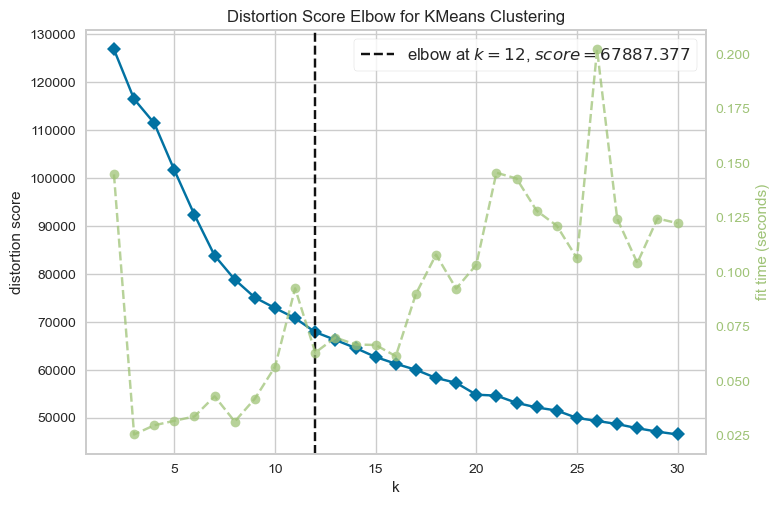

In [55]:
# SSD plot
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=30)
visualizer.fit(X_pca)
visualizer.show();

In [56]:
# Create multiple models for silhouette score
k_values = []
scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X_pca)
    k_values.append(k)
    scores.append(silhouette_score(X_pca, kmeans.labels_, metric='euclidean'))

models = pd.Series(data=scores, index=k_values)

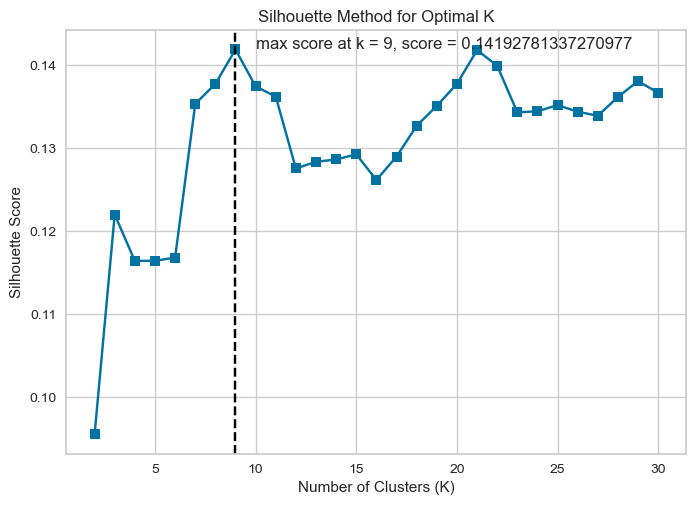

In [ ]:
# Silhouette score plot
optimal_k = models.idxmax()
max_score = models.max()

plt.plot(models, marker='s')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.axvline(x=optimal_k, color='black', linestyle='--')
plt.annotate('max score at k = {}, score = {}'.format(optimal_k, max_score), xy=(optimal_k + 1, max_score))
plt.show()

In [63]:
# Based on the silhouette method, the lowest k value to try would be 9
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=9, random_state=42)

In [74]:
original_df = pd.read_csv('data/cleaned_data.csv', parse_dates=['date'])
original_df.insert(0, 'year', original_df['date'].dt.year)
original_df.insert(1, 'month', original_df['date'].dt.month)
original_df.insert(2, 'day', original_df['date'].dt.day)
original_df.insert(0, 'km_cluster', kmeans.labels_)
original_df.drop('date', inplace=True, axis=1)

#### Analyse the clusters

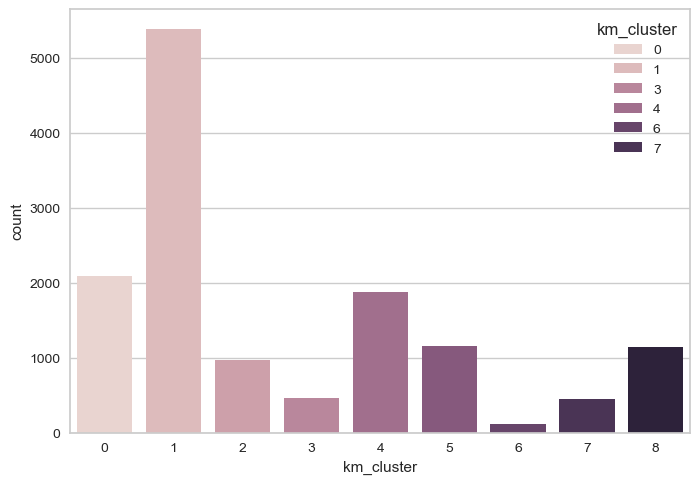

In [75]:
# Plot distribution of the clusters
sns.countplot(data=original_df, x='km_cluster', hue='km_cluster');

In [79]:
km_cluster0 = original_df[original_df['km_cluster'] == 0]
km_cluster0.sample(5)

,km_cluster,year,month,day,category,type,operator,yom,engine,engine_model,...,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities,cause
1320,0,1973,11,12,Accident,Nord 262,Rousseau Aviation,1964,Multi Turboprop Engines,Unknown,...,"Craon, Mayenne",France,Europe,47.848310,-0.951838,Destroyed,5,0,0,Technical failure
6999,0,1991,5,24,Accident,Ilyushin II-76,Metro Cargo Airlines,1989,Multi Jet Engines,Unknown,...,"Bakhtaran, Kermanshah",Iran,Asia,34.323941,47.073589,Destroyed,10,4,0,Technical failure
13240,0,2021,8,6,Unknown,Piper PA-46 (Malibu/Meridian/Mirage/Matrix/M-C...,Opium Events,2010,Unknown,Unknown,...,"Courchevel, Savoie",France,Europe,45.414098,6.634989,Unknown,3,1,0,Human factor
1169,0,1973,6,3,Accident,Tupolev TU-144,Tupolev Industries - GKAP Tupolev OKB,1972,Multi Jet Engines,Kuznetsov NK-144A,...,"Goussainville, Val-d'Oise",France,Europe,49.032317,2.473363,Destroyed,6,6,8,Human factor
6271,0,1988,12,14,Unknown,Boeing 707,GAS Air Cargo - General & Aviation Services,1966,Unknown,Unknown,...,"Karm Umran, Qena",Egypt,Africa,26.254049,29.267547,Unknown,8,8,1,Human factor


In [77]:
km_cluster0.describe()

,km_cluster,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,2082.0,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000
mean,0.0,1990.432277,6.538905,16.204131,1974.325648,46.884575,15.994379,8.192603,3.859750,0.066763
std,0.0,14.275705,3.420923,8.781184,13.011421,8.666161,16.620361,12.740446,8.246417,1.190165
min,0.0,1970.000000,1.000000,1.000000,1929.000000,14.737134,-42.812597,0.000000,0.000000,0.000000
25%,0.0,1978.000000,4.000000,9.000000,1967.000000,42.555990,3.312125,2.000000,0.000000,0.000000
50%,0.0,1988.000000,7.000000,16.000000,1974.000000,47.450098,12.578354,3.000000,1.000000,0.000000
75%,0.0,2001.000000,9.000000,24.000000,1981.000000,52.151859,31.220196,8.000000,4.000000,0.000000
max,0.0,2025.000000,12.000000,31.000000,2022.000000,77.619235,48.944123,78.000000,63.000000,43.000000


In [78]:
km_cluster0.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage,cause
count,2082,2082,2082,2082,2082,2082,2082,2082,2082,2082,2082,2082,2082
unique,4,310,1061,6,247,6,31,7,1462,74,5,7,6
top,Accident,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Unknown,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Zurich-Kloten, Zurich",Russia,Europe,Destroyed,Human factor
freq,1178,304,254,905,1373,875,407,1114,12,238,1535,1119,928


In [80]:
km_cluster1 = original_df[original_df['km_cluster'] == 1]
km_cluster1.sample(5)

,km_cluster,year,month,day,category,type,operator,yom,engine,engine_model,...,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities,cause
4627,1,1983,6,21,Unknown,De Havilland DHC-2 Beaver,Central Air Transport - Canada,1954,Unknown,Unknown,...,"Bonner Lake, Ontario",Canada,North America,49.432744,-88.271637,Unknown,3,1,0,Unknown
3099,1,1978,12,18,Unknown,Cessna 421A Golden Eagle I,Private German,1968,Unknown,Unknown,...,"Tyrrhenian Sea, All World",World,World,33.974482,-118.269835,Unknown,1,0,0,Unknown
895,1,1972,9,23,Unknown,Beechcraft E18,Tobey Inc.,1956,Unknown,Unknown,...,"Newark, New Jersey",United States of America,North America,40.735657,-74.172367,Unknown,2,2,0,Technical failure
13560,1,2024,7,20,Accident,Cessna 208B Grand Caravan,Skydive the Falls,2002,1 Turboprop engine,Unknown,...,"Youngstown-Windsor, New York",United States of America,North America,39.783730,-100.445882,Destroyed,1,1,0,Unknown
4174,1,1981,12,10,Unknown,Cessna 207 Skywagon/Stationair,Spernak Airways,1981,Unknown,Unknown,...,"Tyonek, Alaska",United States of America,North America,61.068429,-151.140914,Unknown,4,4,0,Unknown


In [81]:
km_cluster1.describe()

,km_cluster,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,5380.0,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000
mean,1.0,1992.173606,6.630112,15.733271,1970.964312,39.073097,-100.375418,5.433457,2.453717,0.044052
std,0.0,14.880049,3.506505,8.836583,14.925901,11.435781,21.997533,12.310034,5.936290,0.944506
min,1.0,1970.000000,1.000000,1.000000,1927.000000,-19.996972,-179.491343,0.000000,0.000000,0.000000
25%,1.0,1979.000000,4.000000,8.000000,1961.000000,32.960119,-112.006791,2.000000,0.000000,0.000000
50%,1.0,1990.000000,7.000000,16.000000,1972.000000,39.547692,-98.947015,3.000000,1.000000,0.000000
75%,1.0,2003.000000,10.000000,23.000000,1979.000000,43.528945,-83.044840,5.000000,3.000000,0.000000
max,1.0,2025.000000,12.000000,31.000000,2022.000000,79.990159,-43.814704,159.000000,115.000000,54.000000


In [ ]:
cluster1.select_dtypes(include=['object']).describe()

In [ ]:
cluster2 = original_df[original_df['cluster_1'] == 2]
cluster2.sample(5)

In [ ]:
cluster2.describe()

In [ ]:
cluster2.select_dtypes(include=['object']).describe()

In [ ]:
cluster3 = original_df[original_df['cluster_1'] == 3]
cluster3.sample(5)

In [ ]:
cluster3.describe()

In [ ]:
cluster3.select_dtypes(include=['object']).describe()

In [ ]:
cluster4 = original_df[original_df['cluster_1'] == 4]
cluster4.sample(5)

In [ ]:
cluster4.describe()

In [ ]:
cluster4.select_dtypes(include=['object']).describe()

In [ ]:
cluster5 = original_df[original_df['cluster_1'] == 5]
cluster5.sample(5)

In [ ]:
cluster5.describe()

In [ ]:
cluster5.select_dtypes(include=['object']).describe()

##### Observations

0. 
1. 
2. 
3. 
4. 
5.
6.
7.
8.

### Hierarchical Clustering

In [ ]:
# Dendogram
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
#plt.hlines(y=190,xmin=0,xmax=2000,lw=3,linestyles='--')
#plt.text(x=900,y=220,s='Horizontal line crossing 5 vertical lines',fontsize=20)
plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X_pca, method = 'ward'))
plt.show()

In [ ]:
# Fit model with optimal k
ac = AgglomerativeClustering(n_clusters= 5, metric='euclidean', linkage='ward')
ac.fit(X_pca)

In [ ]:
original_df.insert(1, 'ac_cluster', ac.labels_)

#### Analyse the clusters

In [ ]:
# Plot distribution of the clusters
sns.countplot(data=original_df, x='ac_cluster', hue='ac_cluster');

##### Observations

0.
1.
2.
3.
4.
5.
6.
7.
8.

### DBSCAN

In [ ]:
# Plot different proportion of outliers based on the epsilon value
# The minimum points per cluster will be twice the number of features
models = []
min_samples = len(X_pca.columns) * 2

for eps in np.linspace(0.001, 6, 50):
	dbscan = DBSCAN(eps=eps, min_samples=min_samples)
	dbscan.fit(X_pca)

	unique, counts = np.unique(dbscan.labels_, return_counts=True)
	freqs = dict(zip(unique, counts))

	percentage = freqs[-1] / len(X_pca)
	
	models.append({'epsilon': eps, 'outliers': percentage})

models_df = pd.DataFrame(models)

In [ ]:
# Outlier proportion vs. eps value lineplot
sns.lineplot(data=models_df, x='epsilon', y='outliers');

In [ ]:
# Based on the outlier plot, a reasonable epsilon value would be 4 (where the "elbow" is)
model = DBSCAN(eps=4, min_samples=min_samples)
model.fit(X_pca)

In [ ]:
# Add cluster to dataframe
original_df.insert(2, 'db_cluster', model.labels_)

In [ ]:
original_df.sample(5)

In [ ]:
original_df['db_cluster'].value_counts()

#### Analyse clusters

In [ ]:
outlier_mask = original_df['db_cluster'] == -1
outliers = original_df[outlier_mask]
outliers.sample(5)

In [ ]:
outliers.describe()

In [ ]:
outliers.select_dtypes(include=['object']).describe()

In [ ]:
outliers.describe()

In [ ]:
outliers.select_dtypes(include=['object']).describe()

In [ ]:
not_outliers = original_df[~outlier_mask]
not_outliers.sample(5)

In [ ]:
not_outliers.describe()

In [ ]:
not_outliers.select_dtypes(include=['object']).describe()

#### Observations

**Outliers:** bla bla bla
**Not outliers:** bla bla bla

### Compare the different clusterings

bla bla bla

## End